In [3]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [4]:
# get data from .csv file and parse them 
#filename = filename.csv
def get_data(filename):
    with open(filename, 'r') as f:
        dat = csv.reader(f, delimiter = ',')
        #get column name from first row
        col_name = next(dat)
        #get all the rows as a list
        data = list(dat)
        #return data as numpy array
    return np.array(data)


#Processing Dataset # concatenation of paired up img_ids
# args: data: humanobserved-features , # pair: list of same or diff pairs. 
def process_data(data, pair, x):
    
    same = []
    for i in range(len(pair)):
        for j in range(len(data)):
            if pair[i][x] == data[j][0]:
                a = np.concatenate((data[j][1:], [pair[i][-1]]), axis = 0) 
                #a = (data[j][1:])
                same.append(a)
    
    return np.array(same)

In [5]:
data = get_data('HumanObserved-Features-Data.csv')
dat = np.array([data[d][1:] for d in range(len(data))])
d_pair = get_data('diffn_pairs.csv')
s_pair = get_data('same_pairs.csv')

print(dat.shape)
#print(d_pair.shape)
#print(s_pair.shape)


(1026, 10)


# concatenate same data pair

In [6]:

s1_h = process_data(dat, s_pair, x = 0)
s2_h = process_data(dat, s_pair, x = 1)


s = np.array(np.concatenate((s1_h,s2_h), axis = 1))
# for i in range(len(s_pair)):
#     so= np.concatenate((s, [s_pair[i][-1]]), axis = 1)
s = np.delete(s, 9, 1)
print(s.shape)
print(s[1])

(791, 19)
['2' '1' '1' '0' '2' '2' '0' '1' '2' '2' '1' '0' '3' '2' '2' '1' '2' '2'
 '1']


# concatenate diff data pair

In [7]:
d1_h = process_data(dat, d_pair, x = 0)
d2_h = process_data(dat, d_pair, x = 1)

d = np.array(np.concatenate((d1_h,d2_h), axis = 1))
# get equal number of different pairs as same pair, to get rid of bias. 

print(d.shape)

(293032, 20)


# Concatenate same and different pairs and randomly shuffle 

In [8]:
d = np.delete(d, 9, 1)
np.random.shuffle(d)
d = d[:791] 

h_obs_con = np.concatenate((s, d), axis = 0)
np.random.shuffle(h_obs_con) # randomly mix same and diff pairs 
print(h_obs_con.shape)
print(h_obs_con[:5]) # print first five rows of the parsed data

(1582, 19)
[['2' '2' '1' '3' '0' '2' '0' '1' '1' '0' '1' '1' '2' '1' '2' '1' '1' '1'
  '0']
 ['3' '1' '1' '0' '2' '2' '3' '2' '2' '2' '1' '0' '1' '2' '2' '1' '3' '2'
  '1']
 ['3' '4' '1' '0' '2' '2' '1' '0' '2' '3' '1' '1' '1' '2' '1' '1' '0' '2'
  '0']
 ['3' '2' '1' '3' '2' '2' '0' '4' '2' '2' '1' '1' '3' '0' '2' '0' '1' '1'
  '0']
 ['1' '1' '0' '1' '0' '3' '1' '0' '1' '1' '0' '0' '1' '0' '1' '3' '2' '2'
  '0']]


In [10]:
# get ground truth, target vector 't', which is the last column of the dataset. 
target = np.array([h_obs_con[t][-1] for t in range(len(h_obs_con))]).astype(float)
print(target.shape)

##get data : human observed features concatenated (18 features)

DataMatrix = np.array([h_obs_con[t][:-1] for t in range(len(h_obs_con))]).astype(float)
print(DataMatrix.shape)


(1582,)
(1582, 18)


# LINEAR REGRESSION 

In [11]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03  # regularizer for Closed Form Solution: tunable hyperparameter
TrainingPercent = 80  # 80% of sample input will be assigned as training data set
ValidationPercent = 10 # 10% for validation
TestPercent = 10  # 10% for Testing the model
M = 15 # no of clusters # radial basis functions  # also represents the complexity of the model
PHI = []  # store basis functions in this list
IsSynthetic = False   


In [102]:
# 80% o/p target vector assigned as training 
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

#80 of the data matrix assigned as training
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData)*(TrainingPercent*0.01)))
    d2 = rawData[:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#10% of dataset assigned a validation
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[TrainingCount+1 : V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#10% of target vector for validation
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

# get variance of the training data and generate a diagonal matrix of variances also called big sigma. 
#generate a 41x41 diagonal matrix with all other elements as zero.
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))  # creating a dummy zero squares matrix m X m
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) # length of the training data 80% of DataT 
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))  # np.var : compute variance 
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]  # diagonal elements of bigsigma : variance 
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        # not necessary
        BigSigma = np.dot(200,BigSigma)   # scaling the variance by multiplying it by 200
    ##print ("BigSigma Generated..")
    return BigSigma


#computing the exponential term of the Gaussian basis function matrices and return a scalar value
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

#computing Gaussian Radial basis function.
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

#generating design matrix
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    #generate a matriz placeholder 
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    
    # iterate : for each mu(anchor point), iterate over the row data points
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)): # 
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI


#closed form solution # w/ regularizer  : Returns w*
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0])) # identity matrix
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)  
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

# #contruct new design matrix based on validation and testing data
# def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
#     DataT = np.transpose(Data)
#     TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
#     PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
#     BigSigInv = np.linalg.inv(BigSigma)
#     for  C in range(0,len(MuMatrix)):
#         for R in range(0,int(TrainingLen)):
#             PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
#     #print ("PHI Generated..")
#     return PHI

#validation 
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

# computing Erms
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range(0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        
        # get accuracy. If output == target value, add 1 to couter. 
        # accuracy =(no of correct match/total number)* 100
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    saccuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
#    print ("Accuracy Generated..")
#    print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(saccuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

In [13]:
#generate training target and training data
TrainingTarget = np.array(GenerateTrainingTarget(target,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(DataMatrix,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(1266,)
(1266, 18)


In [14]:
# Generate validation target and data.
ValDataAct = np.array(GenerateValTargetVector(target,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(DataMatrix,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
#ValData[:5]

(158,)
(158, 18)


In [15]:
#generate test target and data
TestDataAct = np.array(GenerateValTargetVector(target,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(DataMatrix,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)

#TestData[:5]
# plt.hist(TestData, bins = 'auto')
# plt.show()

(157,)
(157, 18)


In [22]:
Erms_Tr = []
Erms_Val = []
Erms_Test = []


ErmsArr = []
AccuracyArr = []

# k means clustering using scikit learn, # fit in the data after clustering
kmeans = KMeans(n_clusters=M, random_state=0).fit(TrainingData)
#centroid of clusters
Mu = kmeans.cluster_centers_

# based on centroid, calculate variance 
BigSigma     = GenerateBigSigma(DataMatrix.T, Mu, TrainingPercent, IsSynthetic)

#GetPhiMatrix: to get radial basis function# 1.3 design matrix
TRAINING_PHI = GetPhiMatrix(DataMatrix.T, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData.T, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData.T, Mu, BigSigma, 100)


TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

#     #print(TRAINING_PHI[0])
    
# print(Mu.shape)
# print(BigSigma.shape)

In [1]:
#print out the shapes of all the matrix generated
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(TestTarget)
print(VAL_PHI.shape)
print(TEST_PHI.shape)
print(W.shape)

NameError: name 'Mu' is not defined

In [166]:
def Accuracy(OutputValue, TargetValue ):

    wrong   = 0
    right   = 0

    for i,j in zip(OutputValue, TargetValue):
    
        if i == j:
            right = right + 1
        else:
            wrong = wrong + 1
    return str(right/(right+wrong)*100)
#print("Errors: " + str(wrong), " Correct :" + str(right))

#print(" Accuracy: " + Acc + '%')
#Accuracy(Out_Test_Target,TrainingTarget)

In [171]:

W_Now        = np.dot(220, W) # unnecessary
La           = 5   #lambda: 0.01 , .05, .1, .5, 1, 5, 10
learningRate = 0.01  # experimnet with 0.01 to 0.5
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
#m = 15
E_Tr   = []
Acc_TR = []
Acc_Val = []
Acc_Test = []

Er = []
W_Matrix = []
# no. of iteration->hyperparameter# 
#iteration over 1000 data points. adjustable: can stop when Erms value is stagnant
#400 iterations is used when changing different M

for i in range(0, 500):  
#    learningRate = 0.1/np.sqrt(5*(i+1)) # learning rate decreases with every iteration, # self adjusting 
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)  # 
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    # eqn 10
    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W  # new weight
    W_Now         = W_T_Next # updated weight
    W_Matrix.append(W_Now)
    

    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT, TrainingTarget)
    Er.append(Erms_TR)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    A_TR = Accuracy(np.around(TR_TEST_OUT),TrainingTarget)
    Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    A_Val = Accuracy((np.around(VAL_TEST_OUT)),TrainingTarget)
    Acc_Val.append(A_Val)
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    A_Test = Accuracy(np.around(TEST_OUT),TrainingTarget)
    Acc_Test.append(float(A_Test))




print(TrainingTarget.shape)
print(TR_TEST_OUT.shape)
print(TRAINING_PHI.shape)
print(Acc_Val[60])

#print(output)
#print(TR_TEST_OUT)

(1266,)
(1266,)
(1266, 15)
51.26582278481012


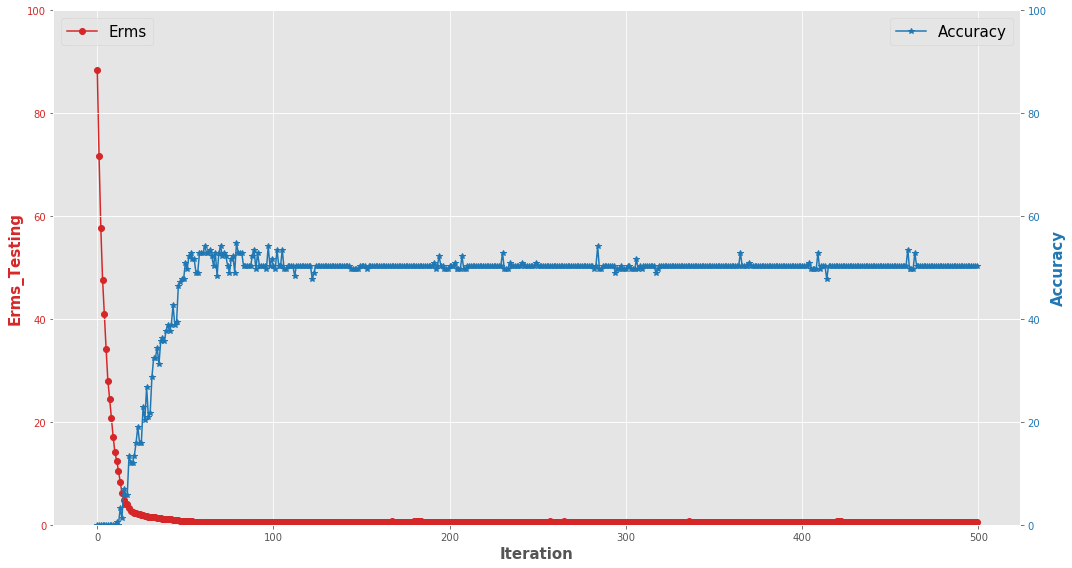

In [235]:
# #plotting Erms_Test vs iteration
iterations = 1000

# plt.figure(figsize=(10,6))
# plt.plot(range(len(Acc_Val)), Acc_Val,'bo', label= 'Accuracy')
# plt.plot(range(len(L_Erms_Test)), L_Erms_Test, 'ro', label = 'Erms')
# plt.grid(True)

# plt.xlabel("Iteration number")
# plt.ylabel("L_Erms_Test")
# plt.xlim([-0.05*iterations,1.05*iterations])

# plt.legend()
# plt.savefig('Erms_Test_iteration.png')
# plt.show()


fig, ax1 = plt.subplots(figsize = (15, 8))

ax1.grid(True)
color = 'tab:red'
ax1.set_xlabel('Iteration', fontweight = 'bold', fontsize = '15')
ax1.set_ylabel('Erms_Testing',fontweight = 'bold', fontsize = '15', color=color)
ax1.plot(range(len(L_Erms_Test)), L_Erms_Test, '-o', color=color, label = 'Erms')
ax1.set_ylim(0, 100)
ax1.legend(loc = 'upper left', fontsize = 15)
ax1.tick_params(axis='y', labelcolor=color)



ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(True)
color = 'tab:blue'
ax2.set_ylabel('Accuracy',fontweight = 'bold', fontsize = '15', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(Acc_Test)), Acc_Test, '-*', markersize = 6, color=color, label = 'Accuracy')
ax2.set_ylim(0, 100)
ax2.legend(loc ='upper right', fontsize = 15)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()
plt.savefig('Erms_Acc_Conc_LinR.png')